In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, \
                                    Flatten, Conv1D, MaxPooling1D, Dropout, \
                                    Concatenate, GlobalMaxPool1D, GlobalAvgPool1D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_cnn(conv_num=1):
    filter_size = 32

    input_layer = Input(shape=input_shape)
    x = input_layer

    layer_outputs = []
    for i in range(conv_num):
        x = Conv1D (kernel_size=5, filters=filter_size*(2**(i//4)), 
                          strides=1, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling1D(pool_size=3, strides=3)(x)
        layer_outputs.append(x)    
    
    x = Concatenate()([GlobalMaxPool1D()(output) for output in layer_outputs[-2:]])
    x = Dropout(0.5)(x)
    x = Dense(output_size, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=x)
    return model

In [9]:
for i in range(3, 9):
    model = build_cnn(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 16000, 32)    192         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 16000, 32)    128         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activatio

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 16000, 32)    192         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_7 (Batch (None, 16000, 32)    128         conv1d_7[0][0]                   
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 16000, 32)    0           batch_normalization_v1_7[0][0]   
__________________________________________________________________________________________________
max_poolin

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 16000, 32)    192         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_18 (Batc (None, 16000, 32)    128         conv1d_18[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 16000, 32)    0           batch_normalization_v1_18[0][0]  
__________________________________________________________________________________________________
max_poolin

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 7.5153 - acc: 0.0786
Epoch 00001: val_loss improved from inf to 2.63257, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_BN_3_conv_checkpoint/001-2.6326.hdf5
36805/36805 [==============================] - 30s 817us/sample - loss: 7.5152 - acc: 0.0786 - val_loss: 2.6326 - val_acc: 0.1297
Epoch 2/500
36736/36805 [============================>.] - ETA: 0s - loss: 4.9158 - acc: 0.0833
Epoch 00002: val_loss improved from 2.63257 to 2.55878, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_BN_3_conv_checkpoint/002-2.5588.hdf5
36805/36805 [==============================] - 27s 729us/sample - loss: 4.9150 - acc: 0.0834 - val_loss: 2.5588 - val_acc: 0.2001
Epoch 3/500
36800/36805 [============================>.

Epoch 21/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8135 - acc: 0.3989
Epoch 00021: val_loss improved from 1.53249 to 1.51471, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_BN_3_conv_checkpoint/021-1.5147.hdf5
36805/36805 [==============================] - 27s 724us/sample - loss: 1.8135 - acc: 0.3989 - val_loss: 1.5147 - val_acc: 0.5712
Epoch 22/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7788 - acc: 0.4082
Epoch 00022: val_loss improved from 1.51471 to 1.46595, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_BN_3_conv_checkpoint/022-1.4660.hdf5
36805/36805 [==============================] - 27s 727us/sample - loss: 1.7788 - acc: 0.4082 - val_loss: 1.4660 - val_acc: 0.5821
Epoch 23/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.7486 - acc: 0.4214
Epoch 00023: val_loss improved from 1.46595 to 1.45387, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_BN_

Epoch 44/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4439 - acc: 0.5314
Epoch 00044: val_loss improved from 1.13946 to 1.11686, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_BN_3_conv_checkpoint/044-1.1169.hdf5
36805/36805 [==============================] - 27s 726us/sample - loss: 1.4441 - acc: 0.5314 - val_loss: 1.1169 - val_acc: 0.6914
Epoch 45/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4386 - acc: 0.5349
Epoch 00045: val_loss improved from 1.11686 to 1.10216, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_BN_3_conv_checkpoint/045-1.1022.hdf5
36805/36805 [==============================] - 27s 730us/sample - loss: 1.4388 - acc: 0.5349 - val_loss: 1.1022 - val_acc: 0.6897
Epoch 46/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4256 - acc: 0.5383
Epoch 00046: val_loss improved from 1.10216 to 1.08820, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_BN_

36800/36805 [============================>.] - ETA: 0s - loss: 1.3304 - acc: 0.5721
Epoch 00068: val_loss did not improve from 0.97644
36805/36805 [==============================] - 27s 724us/sample - loss: 1.3305 - acc: 0.5721 - val_loss: 1.0035 - val_acc: 0.7219
Epoch 69/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3318 - acc: 0.5686
Epoch 00069: val_loss did not improve from 0.97644
36805/36805 [==============================] - 27s 724us/sample - loss: 1.3317 - acc: 0.5686 - val_loss: 1.0527 - val_acc: 0.7147
Epoch 70/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.3225 - acc: 0.5720
Epoch 00070: val_loss did not improve from 0.97644
36805/36805 [==============================] - 27s 729us/sample - loss: 1.3226 - acc: 0.5721 - val_loss: 0.9928 - val_acc: 0.7284
Epoch 71/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3200 - acc: 0.5740
Epoch 00071: val_loss did not improve from 0.97644
36805/36805 [==================

Epoch 95/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2677 - acc: 0.5923
Epoch 00095: val_loss did not improve from 0.91266
36805/36805 [==============================] - 27s 728us/sample - loss: 1.2678 - acc: 0.5922 - val_loss: 0.9305 - val_acc: 0.7419
Epoch 96/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.2691 - acc: 0.5927
Epoch 00096: val_loss did not improve from 0.91266
36805/36805 [==============================] - 27s 729us/sample - loss: 1.2688 - acc: 0.5928 - val_loss: 0.9495 - val_acc: 0.7398
Epoch 97/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2691 - acc: 0.5893
Epoch 00097: val_loss did not improve from 0.91266
36805/36805 [==============================] - 27s 727us/sample - loss: 1.2690 - acc: 0.5894 - val_loss: 0.9216 - val_acc: 0.7498
Epoch 98/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2653 - acc: 0.5921
Epoch 00098: val_loss did not improve from 0.91266
36805/36805 [=====

36800/36805 [============================>.] - ETA: 0s - loss: 1.2218 - acc: 0.6048
Epoch 00123: val_loss did not improve from 0.87731
36805/36805 [==============================] - 27s 727us/sample - loss: 1.2219 - acc: 0.6048 - val_loss: 0.9324 - val_acc: 0.7447
Epoch 124/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2355 - acc: 0.6032
Epoch 00124: val_loss did not improve from 0.87731
36805/36805 [==============================] - 27s 731us/sample - loss: 1.2356 - acc: 0.6032 - val_loss: 0.8853 - val_acc: 0.7440
Epoch 125/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2241 - acc: 0.6084
Epoch 00125: val_loss improved from 0.87731 to 0.86891, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_BN_3_conv_checkpoint/125-0.8689.hdf5
36805/36805 [==============================] - 27s 730us/sample - loss: 1.2241 - acc: 0.6084 - val_loss: 0.8689 - val_acc: 0.7512
Epoch 126/500
36800/36805 [============================>.] - ETA: 0

36800/36805 [============================>.] - ETA: 0s - loss: 1.2098 - acc: 0.6110
Epoch 00150: val_loss did not improve from 0.83825
36805/36805 [==============================] - 27s 730us/sample - loss: 1.2098 - acc: 0.6109 - val_loss: 0.8852 - val_acc: 0.7503
Epoch 151/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1925 - acc: 0.6168
Epoch 00151: val_loss did not improve from 0.83825
36805/36805 [==============================] - 27s 726us/sample - loss: 1.1924 - acc: 0.6168 - val_loss: 0.9658 - val_acc: 0.7270
Epoch 152/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1969 - acc: 0.6157
Epoch 00152: val_loss did not improve from 0.83825
36805/36805 [==============================] - 27s 724us/sample - loss: 1.1973 - acc: 0.6156 - val_loss: 0.8859 - val_acc: 0.7503
Epoch 153/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.1924 - acc: 0.6163
Epoch 00153: val_loss did not improve from 0.83825
36805/36805 [===============

36800/36805 [============================>.] - ETA: 0s - loss: 1.1676 - acc: 0.6220
Epoch 00178: val_loss did not improve from 0.82558
36805/36805 [==============================] - 27s 729us/sample - loss: 1.1676 - acc: 0.6220 - val_loss: 0.8319 - val_acc: 0.7701
Epoch 179/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1725 - acc: 0.6218
Epoch 00179: val_loss did not improve from 0.82558
36805/36805 [==============================] - 27s 731us/sample - loss: 1.1724 - acc: 0.6218 - val_loss: 0.8461 - val_acc: 0.7584
Epoch 180/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1798 - acc: 0.6229
Epoch 00180: val_loss improved from 0.82558 to 0.82100, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_BN_3_conv_checkpoint/180-0.8210.hdf5
36805/36805 [==============================] - 27s 729us/sample - loss: 1.1798 - acc: 0.6229 - val_loss: 0.8210 - val_acc: 0.7687
Epoch 181/500
36736/36805 [============================>.] - ETA: 0

36800/36805 [============================>.] - ETA: 0s - loss: 1.1488 - acc: 0.6327
Epoch 00206: val_loss improved from 0.81648 to 0.80905, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_BN_3_conv_checkpoint/206-0.8090.hdf5
36805/36805 [==============================] - 27s 727us/sample - loss: 1.1487 - acc: 0.6327 - val_loss: 0.8090 - val_acc: 0.7736
Epoch 207/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1569 - acc: 0.6280
Epoch 00207: val_loss did not improve from 0.80905
36805/36805 [==============================] - 27s 728us/sample - loss: 1.1569 - acc: 0.6280 - val_loss: 0.8127 - val_acc: 0.7682
Epoch 208/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.1551 - acc: 0.6263
Epoch 00208: val_loss did not improve from 0.80905
36805/36805 [==============================] - 27s 725us/sample - loss: 1.1552 - acc: 0.6262 - val_loss: 0.8195 - val_acc: 0.7696
Epoch 209/500
36800/36805 [============================>.] - ETA: 0

36800/36805 [============================>.] - ETA: 0s - loss: 1.1378 - acc: 0.6330
Epoch 00234: val_loss did not improve from 0.77916
36805/36805 [==============================] - 27s 732us/sample - loss: 1.1378 - acc: 0.6330 - val_loss: 0.7941 - val_acc: 0.7754
Epoch 235/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1309 - acc: 0.6369
Epoch 00235: val_loss did not improve from 0.77916
36805/36805 [==============================] - 27s 731us/sample - loss: 1.1308 - acc: 0.6369 - val_loss: 0.8453 - val_acc: 0.7629
Epoch 236/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1303 - acc: 0.6376
Epoch 00236: val_loss did not improve from 0.77916
36805/36805 [==============================] - 27s 730us/sample - loss: 1.1303 - acc: 0.6375 - val_loss: 0.8034 - val_acc: 0.7689
Epoch 237/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1351 - acc: 0.6339
Epoch 00237: val_loss did not improve from 0.77916
36805/36805 [===============

36736/36805 [============================>.] - ETA: 0s - loss: 1.1159 - acc: 0.6412
Epoch 00263: val_loss did not improve from 0.77747
36805/36805 [==============================] - 27s 727us/sample - loss: 1.1160 - acc: 0.6412 - val_loss: 0.7954 - val_acc: 0.7775
Epoch 264/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.1145 - acc: 0.6402
Epoch 00264: val_loss did not improve from 0.77747
36805/36805 [==============================] - 27s 727us/sample - loss: 1.1141 - acc: 0.6403 - val_loss: 0.8314 - val_acc: 0.7596
Epoch 265/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1290 - acc: 0.6363
Epoch 00265: val_loss did not improve from 0.77747
36805/36805 [==============================] - 27s 728us/sample - loss: 1.1294 - acc: 0.6362 - val_loss: 0.8436 - val_acc: 0.7519
Epoch 266/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1115 - acc: 0.6414
Epoch 00266: val_loss did not improve from 0.77747
36805/36805 [===============

Epoch 292/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1076 - acc: 0.6424
Epoch 00292: val_loss did not improve from 0.76100
36805/36805 [==============================] - 27s 730us/sample - loss: 1.1075 - acc: 0.6424 - val_loss: 0.8388 - val_acc: 0.7647
Epoch 293/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1051 - acc: 0.6425
Epoch 00293: val_loss did not improve from 0.76100
36805/36805 [==============================] - 27s 726us/sample - loss: 1.1054 - acc: 0.6425 - val_loss: 0.7822 - val_acc: 0.7792
Epoch 294/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1160 - acc: 0.6377
Epoch 00294: val_loss did not improve from 0.76100
36805/36805 [==============================] - 27s 728us/sample - loss: 1.1161 - acc: 0.6377 - val_loss: 0.8622 - val_acc: 0.7473
Epoch 295/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.1036 - acc: 0.6427
Epoch 00295: val_loss did not improve from 0.76100
36805/36805 [=

Epoch 321/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0948 - acc: 0.6454
Epoch 00321: val_loss did not improve from 0.76036
36805/36805 [==============================] - 27s 730us/sample - loss: 1.0947 - acc: 0.6454 - val_loss: 0.7824 - val_acc: 0.7808
Epoch 322/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.0972 - acc: 0.6470
Epoch 00322: val_loss did not improve from 0.76036
36805/36805 [==============================] - 27s 727us/sample - loss: 1.0970 - acc: 0.6470 - val_loss: 0.7796 - val_acc: 0.7745
Epoch 323/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1037 - acc: 0.6448
Epoch 00323: val_loss did not improve from 0.76036
36805/36805 [==============================] - 27s 728us/sample - loss: 1.1036 - acc: 0.6447 - val_loss: 0.7766 - val_acc: 0.7727
Epoch 324/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.0998 - acc: 0.6467
Epoch 00324: val_loss did not improve from 0.76036
36805/36805 [=

Epoch 350/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.0814 - acc: 0.6515
Epoch 00350: val_loss did not improve from 0.74403
36805/36805 [==============================] - 27s 731us/sample - loss: 1.0812 - acc: 0.6515 - val_loss: 0.7809 - val_acc: 0.7766
Epoch 351/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0855 - acc: 0.6476
Epoch 00351: val_loss did not improve from 0.74403
36805/36805 [==============================] - 27s 727us/sample - loss: 1.0854 - acc: 0.6477 - val_loss: 0.8349 - val_acc: 0.7612
Epoch 352/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0866 - acc: 0.6485
Epoch 00352: val_loss did not improve from 0.74403
36805/36805 [==============================] - 27s 726us/sample - loss: 1.0866 - acc: 0.6484 - val_loss: 0.7843 - val_acc: 0.7745
Epoch 353/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0872 - acc: 0.6508
Epoch 00353: val_loss did not improve from 0.74403
36805/36805 [=

Epoch 379/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.0844 - acc: 0.6518
Epoch 00379: val_loss did not improve from 0.74383
36805/36805 [==============================] - 27s 728us/sample - loss: 1.0841 - acc: 0.6519 - val_loss: 0.7693 - val_acc: 0.7815
Epoch 380/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.0880 - acc: 0.6489
Epoch 00380: val_loss did not improve from 0.74383
36805/36805 [==============================] - 27s 731us/sample - loss: 1.0876 - acc: 0.6490 - val_loss: 0.8155 - val_acc: 0.7743
Epoch 381/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.0805 - acc: 0.6522
Epoch 00381: val_loss did not improve from 0.74383
36805/36805 [==============================] - 27s 727us/sample - loss: 1.0804 - acc: 0.6522 - val_loss: 0.7633 - val_acc: 0.7813
Epoch 382/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0742 - acc: 0.6536
Epoch 00382: val_loss did not improve from 0.74383
36805/36805 [=

Epoch 408/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.0695 - acc: 0.6534
Epoch 00408: val_loss did not improve from 0.73090
36805/36805 [==============================] - 27s 728us/sample - loss: 1.0696 - acc: 0.6534 - val_loss: 0.7529 - val_acc: 0.7848
Epoch 409/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0729 - acc: 0.6502
Epoch 00409: val_loss did not improve from 0.73090
36805/36805 [==============================] - 27s 729us/sample - loss: 1.0729 - acc: 0.6502 - val_loss: 0.7383 - val_acc: 0.7897
Epoch 410/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0684 - acc: 0.6559
Epoch 00410: val_loss did not improve from 0.73090
36805/36805 [==============================] - 27s 729us/sample - loss: 1.0683 - acc: 0.6559 - val_loss: 0.7601 - val_acc: 0.7822
Epoch 411/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.0719 - acc: 0.6530
Epoch 00411: val_loss did not improve from 0.73090
36805/36805 [=

Epoch 438/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0637 - acc: 0.6585
Epoch 00438: val_loss did not improve from 0.73090
36805/36805 [==============================] - 27s 729us/sample - loss: 1.0637 - acc: 0.6584 - val_loss: 0.7505 - val_acc: 0.7836
Epoch 439/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.0728 - acc: 0.6517
Epoch 00439: val_loss did not improve from 0.73090
36805/36805 [==============================] - 27s 728us/sample - loss: 1.0725 - acc: 0.6517 - val_loss: 0.8019 - val_acc: 0.7743
Epoch 440/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0628 - acc: 0.6573
Epoch 00440: val_loss did not improve from 0.73090
36805/36805 [==============================] - 27s 728us/sample - loss: 1.0629 - acc: 0.6573 - val_loss: 0.8742 - val_acc: 0.7433
Epoch 441/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0612 - acc: 0.6550
Epoch 00441: val_loss did not improve from 0.73090
36805/36805 [=

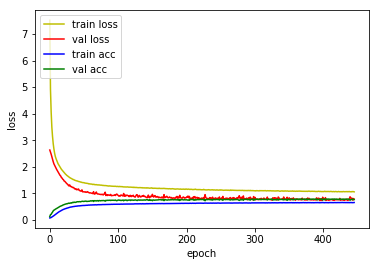

4815/4815 [==============================] - 2s 383us/sample - loss: 0.8076 - acc: 0.7632
Loss: 0.8075879554758438 Accuracy: 0.76323986

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 6.4897 - acc: 0.0891
Epoch 00001: val_loss improved from inf to 2.63608, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_BN_4_conv_checkpoint/001-2.6361.hdf5
36805/36805 [==============================] - 31s 851us/sample - loss: 6.4893 - acc: 0.0891 - val_loss: 2.6361 - val_acc: 0.1705
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 4.1824 - acc: 0.1183
Epoch 00002: val_loss improved from 2.63608 to 2.54053, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_BN_4_conv_checkpoint/002-2.5405.hdf5
36805/36805 [==============================] - 28s 754us/sample - loss: 4.1826 - acc: 0.1183 - val_loss: 2.5405 - val_acc: 0.2590
Epoch 3/500
36800/36805 [===================

Epoch 22/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4808 - acc: 0.5134
Epoch 00022: val_loss improved from 1.15711 to 1.11233, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_BN_4_conv_checkpoint/022-1.1123.hdf5
36805/36805 [==============================] - 28s 753us/sample - loss: 1.4807 - acc: 0.5134 - val_loss: 1.1123 - val_acc: 0.7074
Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4524 - acc: 0.5245
Epoch 00023: val_loss improved from 1.11233 to 1.08830, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_BN_4_conv_checkpoint/023-1.0883.hdf5
36805/36805 [==============================] - 28s 753us/sample - loss: 1.4523 - acc: 0.5245 - val_loss: 1.0883 - val_acc: 0.7007
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4303 - acc: 0.5355
Epoch 00024: val_loss improved from 1.08830 to 1.06968, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_BN_

36800/36805 [============================>.] - ETA: 0s - loss: 1.1616 - acc: 0.6318
Epoch 00045: val_loss did not improve from 0.81855
36805/36805 [==============================] - 28s 757us/sample - loss: 1.1616 - acc: 0.6318 - val_loss: 0.8203 - val_acc: 0.7761
Epoch 46/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.1559 - acc: 0.6337
Epoch 00046: val_loss did not improve from 0.81855
36805/36805 [==============================] - 28s 755us/sample - loss: 1.1558 - acc: 0.6336 - val_loss: 0.8203 - val_acc: 0.7720
Epoch 47/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1539 - acc: 0.6361
Epoch 00047: val_loss improved from 0.81855 to 0.79790, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_BN_4_conv_checkpoint/047-0.7979.hdf5
36805/36805 [==============================] - 28s 758us/sample - loss: 1.1538 - acc: 0.6362 - val_loss: 0.7979 - val_acc: 0.7813
Epoch 48/500
36800/36805 [============================>.] - ETA: 0s -

Epoch 71/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0290 - acc: 0.6760
Epoch 00071: val_loss did not improve from 0.69789
36805/36805 [==============================] - 28s 755us/sample - loss: 1.0290 - acc: 0.6759 - val_loss: 0.6992 - val_acc: 0.8046
Epoch 72/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.0308 - acc: 0.6748
Epoch 00072: val_loss did not improve from 0.69789
36805/36805 [==============================] - 28s 753us/sample - loss: 1.0308 - acc: 0.6749 - val_loss: 0.7048 - val_acc: 0.8008
Epoch 73/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.0323 - acc: 0.6780
Epoch 00073: val_loss did not improve from 0.69789
36805/36805 [==============================] - 28s 755us/sample - loss: 1.0324 - acc: 0.6781 - val_loss: 0.7122 - val_acc: 0.8013
Epoch 74/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.0275 - acc: 0.6772
Epoch 00074: val_loss improved from 0.69789 to 0.67505, saving model 

36736/36805 [============================>.] - ETA: 0s - loss: 0.9453 - acc: 0.7032
Epoch 00098: val_loss improved from 0.63542 to 0.62261, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_BN_4_conv_checkpoint/098-0.6226.hdf5
36805/36805 [==============================] - 28s 753us/sample - loss: 0.9457 - acc: 0.7031 - val_loss: 0.6226 - val_acc: 0.8220
Epoch 99/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9581 - acc: 0.6995
Epoch 00099: val_loss did not improve from 0.62261
36805/36805 [==============================] - 28s 756us/sample - loss: 0.9581 - acc: 0.6995 - val_loss: 0.6450 - val_acc: 0.8195
Epoch 100/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.9499 - acc: 0.7023
Epoch 00100: val_loss did not improve from 0.62261
36805/36805 [==============================] - 28s 755us/sample - loss: 0.9498 - acc: 0.7022 - val_loss: 0.6282 - val_acc: 0.8246
Epoch 101/500
36736/36805 [============================>.] - ETA: 0s

36800/36805 [============================>.] - ETA: 0s - loss: 0.8981 - acc: 0.7183
Epoch 00125: val_loss did not improve from 0.59521
36805/36805 [==============================] - 28s 755us/sample - loss: 0.8980 - acc: 0.7183 - val_loss: 0.5991 - val_acc: 0.8304
Epoch 126/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9044 - acc: 0.7163
Epoch 00126: val_loss did not improve from 0.59521
36805/36805 [==============================] - 28s 751us/sample - loss: 0.9044 - acc: 0.7163 - val_loss: 0.5974 - val_acc: 0.8316
Epoch 127/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.9067 - acc: 0.7169
Epoch 00127: val_loss did not improve from 0.59521
36805/36805 [==============================] - 28s 750us/sample - loss: 0.9068 - acc: 0.7168 - val_loss: 0.5965 - val_acc: 0.8304
Epoch 128/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8941 - acc: 0.7216
Epoch 00128: val_loss improved from 0.59521 to 0.58705, saving model to model/c

Epoch 153/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8595 - acc: 0.7303
Epoch 00153: val_loss did not improve from 0.57073
36805/36805 [==============================] - 28s 755us/sample - loss: 0.8598 - acc: 0.7303 - val_loss: 0.5792 - val_acc: 0.8379
Epoch 154/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8689 - acc: 0.7271
Epoch 00154: val_loss did not improve from 0.57073
36805/36805 [==============================] - 28s 751us/sample - loss: 0.8689 - acc: 0.7272 - val_loss: 0.5708 - val_acc: 0.8397
Epoch 155/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.8573 - acc: 0.7323
Epoch 00155: val_loss improved from 0.57073 to 0.56967, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_BN_4_conv_checkpoint/155-0.5697.hdf5
36805/36805 [==============================] - 28s 757us/sample - loss: 0.8580 - acc: 0.7322 - val_loss: 0.5697 - val_acc: 0.8362
Epoch 156/500
36800/36805 [==========================

Epoch 181/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.8277 - acc: 0.7377
Epoch 00181: val_loss did not improve from 0.54117
36805/36805 [==============================] - 28s 763us/sample - loss: 0.8278 - acc: 0.7376 - val_loss: 0.5690 - val_acc: 0.8372
Epoch 182/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8298 - acc: 0.7402
Epoch 00182: val_loss did not improve from 0.54117
36805/36805 [==============================] - 28s 761us/sample - loss: 0.8298 - acc: 0.7402 - val_loss: 0.5578 - val_acc: 0.8418
Epoch 183/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8284 - acc: 0.7405
Epoch 00183: val_loss did not improve from 0.54117
36805/36805 [==============================] - 28s 761us/sample - loss: 0.8284 - acc: 0.7405 - val_loss: 0.5522 - val_acc: 0.8425
Epoch 184/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.8281 - acc: 0.7412
Epoch 00184: val_loss did not improve from 0.54117
36805/36805 [=

Epoch 210/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8110 - acc: 0.7462
Epoch 00210: val_loss did not improve from 0.52786
36805/36805 [==============================] - 28s 757us/sample - loss: 0.8109 - acc: 0.7463 - val_loss: 0.5373 - val_acc: 0.8477
Epoch 211/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8087 - acc: 0.7438
Epoch 00211: val_loss did not improve from 0.52786
36805/36805 [==============================] - 28s 760us/sample - loss: 0.8094 - acc: 0.7438 - val_loss: 0.5846 - val_acc: 0.8325
Epoch 212/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7999 - acc: 0.7478
Epoch 00212: val_loss did not improve from 0.52786
36805/36805 [==============================] - 28s 759us/sample - loss: 0.7999 - acc: 0.7478 - val_loss: 0.5426 - val_acc: 0.8439
Epoch 213/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8086 - acc: 0.7485
Epoch 00213: val_loss did not improve from 0.52786
36805/36805 [=

Epoch 238/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7804 - acc: 0.7525
Epoch 00238: val_loss did not improve from 0.51835
36805/36805 [==============================] - 28s 761us/sample - loss: 0.7806 - acc: 0.7525 - val_loss: 0.6365 - val_acc: 0.8190
Epoch 239/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.7842 - acc: 0.7541
Epoch 00239: val_loss did not improve from 0.51835
36805/36805 [==============================] - 28s 761us/sample - loss: 0.7839 - acc: 0.7542 - val_loss: 0.5463 - val_acc: 0.8404
Epoch 240/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.7862 - acc: 0.7523
Epoch 00240: val_loss did not improve from 0.51835
36805/36805 [==============================] - 28s 762us/sample - loss: 0.7866 - acc: 0.7522 - val_loss: 0.5420 - val_acc: 0.8479
Epoch 241/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7895 - acc: 0.7516
Epoch 00241: val_loss did not improve from 0.51835
36805/36805 [=

Epoch 267/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7710 - acc: 0.7569
Epoch 00267: val_loss did not improve from 0.51646
36805/36805 [==============================] - 28s 755us/sample - loss: 0.7709 - acc: 0.7569 - val_loss: 0.5431 - val_acc: 0.8484
Epoch 268/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.7604 - acc: 0.7616
Epoch 00268: val_loss did not improve from 0.51646
36805/36805 [==============================] - 28s 760us/sample - loss: 0.7601 - acc: 0.7616 - val_loss: 0.5218 - val_acc: 0.8498
Epoch 269/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7704 - acc: 0.7570
Epoch 00269: val_loss did not improve from 0.51646
36805/36805 [==============================] - 28s 763us/sample - loss: 0.7704 - acc: 0.7570 - val_loss: 0.5403 - val_acc: 0.8430
Epoch 270/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.7737 - acc: 0.7562
Epoch 00270: val_loss did not improve from 0.51646
36805/36805 [=

Epoch 295/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7589 - acc: 0.7572
Epoch 00295: val_loss did not improve from 0.50975
36805/36805 [==============================] - 28s 753us/sample - loss: 0.7590 - acc: 0.7572 - val_loss: 0.5372 - val_acc: 0.8484
Epoch 296/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7645 - acc: 0.7599
Epoch 00296: val_loss did not improve from 0.50975
36805/36805 [==============================] - 28s 756us/sample - loss: 0.7646 - acc: 0.7599 - val_loss: 0.5213 - val_acc: 0.8477
Epoch 297/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.7545 - acc: 0.7597
Epoch 00297: val_loss did not improve from 0.50975
36805/36805 [==============================] - 28s 760us/sample - loss: 0.7545 - acc: 0.7597 - val_loss: 0.5185 - val_acc: 0.8488
Epoch 298/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.7614 - acc: 0.7604
Epoch 00298: val_loss did not improve from 0.50975
36805/36805 [=

Epoch 325/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7415 - acc: 0.7651
Epoch 00325: val_loss did not improve from 0.50975
36805/36805 [==============================] - 28s 760us/sample - loss: 0.7415 - acc: 0.7651 - val_loss: 0.5234 - val_acc: 0.8502
Epoch 326/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7389 - acc: 0.7635
Epoch 00326: val_loss did not improve from 0.50975
36805/36805 [==============================] - 28s 764us/sample - loss: 0.7390 - acc: 0.7635 - val_loss: 0.5155 - val_acc: 0.8516
Epoch 327/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7462 - acc: 0.7645
Epoch 00327: val_loss did not improve from 0.50975
36805/36805 [==============================] - 28s 762us/sample - loss: 0.7462 - acc: 0.7645 - val_loss: 0.5265 - val_acc: 0.8458
Epoch 328/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.7486 - acc: 0.7650
Epoch 00328: val_loss did not improve from 0.50975
36805/36805 [=

Epoch 354/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7354 - acc: 0.7677
Epoch 00354: val_loss did not improve from 0.50429
36805/36805 [==============================] - 28s 757us/sample - loss: 0.7354 - acc: 0.7677 - val_loss: 0.5388 - val_acc: 0.8437
Epoch 355/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7322 - acc: 0.7673
Epoch 00355: val_loss did not improve from 0.50429
36805/36805 [==============================] - 28s 761us/sample - loss: 0.7322 - acc: 0.7673 - val_loss: 0.5129 - val_acc: 0.8563
Epoch 356/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7318 - acc: 0.7696
Epoch 00356: val_loss did not improve from 0.50429
36805/36805 [==============================] - 28s 754us/sample - loss: 0.7318 - acc: 0.7696 - val_loss: 0.5166 - val_acc: 0.8591
Epoch 357/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7341 - acc: 0.7670
Epoch 00357: val_loss did not improve from 0.50429
36805/36805 [=

Epoch 384/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7239 - acc: 0.7726
Epoch 00384: val_loss did not improve from 0.50429
36805/36805 [==============================] - 28s 760us/sample - loss: 0.7239 - acc: 0.7726 - val_loss: 0.5290 - val_acc: 0.8388
Epoch 385/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.7216 - acc: 0.7721
Epoch 00385: val_loss did not improve from 0.50429
36805/36805 [==============================] - 28s 762us/sample - loss: 0.7217 - acc: 0.7721 - val_loss: 0.5308 - val_acc: 0.8470
Epoch 386/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.7215 - acc: 0.7703
Epoch 00386: val_loss did not improve from 0.50429
36805/36805 [==============================] - 28s 765us/sample - loss: 0.7220 - acc: 0.7702 - val_loss: 0.5110 - val_acc: 0.8514
Epoch 387/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.7220 - acc: 0.7735
Epoch 00387: val_loss did not improve from 0.50429
36805/36805 [=

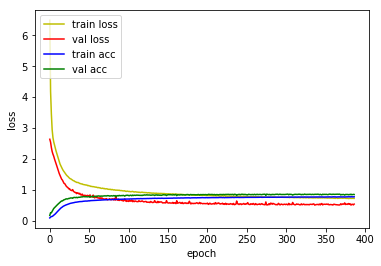

4815/4815 [==============================] - 2s 378us/sample - loss: 0.5789 - acc: 0.8243
Loss: 0.5789255082421585 Accuracy: 0.82429904

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36736/36805 [============================>.] - ETA: 0s - loss: 5.6703 - acc: 0.0917
Epoch 00001: val_loss improved from inf to 2.44667, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_BN_5_conv_checkpoint/001-2.4467.hdf5
36805/36805 [==============================] - 35s 945us/sample - loss: 5.6679 - acc: 0.0917 - val_loss: 2.4467 - val_acc: 0.2222
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.6656 - acc: 0.1348
Epoch 00002: val_loss improved from 2.44667 to 2.05958, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_BN_5_conv_checkpoint/002-2.0596.hdf5
36805/36805 [==============================] - 29s 791us/sample - loss: 3.6656 - acc: 0.1348 - val_loss: 2.0596 - val_acc: 0.3864
Epoch 3/500
36736/36805 [===================

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8674 - acc: 0.7247
Epoch 00023: val_loss improved from 0.58203 to 0.54532, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_BN_5_conv_checkpoint/023-0.5453.hdf5
36805/36805 [==============================] - 29s 782us/sample - loss: 0.8675 - acc: 0.7247 - val_loss: 0.5453 - val_acc: 0.8519
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8462 - acc: 0.7355
Epoch 00024: val_loss did not improve from 0.54532
36805/36805 [==============================] - 29s 776us/sample - loss: 0.8463 - acc: 0.7355 - val_loss: 0.5488 - val_acc: 0.8444
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8271 - acc: 0.7402
Epoch 00025: val_loss improved from 0.54532 to 0.54200, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_BN_5_conv_checkpoint/025-0.5420.hdf5
36805/36805 [==============================] - 29s 782us/sample - loss: 0.82

Epoch 47/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6067 - acc: 0.8123
Epoch 00047: val_loss did not improve from 0.38389
36805/36805 [==============================] - 29s 788us/sample - loss: 0.6067 - acc: 0.8123 - val_loss: 0.4134 - val_acc: 0.8791
Epoch 48/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6066 - acc: 0.8153
Epoch 00048: val_loss did not improve from 0.38389
36805/36805 [==============================] - 29s 787us/sample - loss: 0.6065 - acc: 0.8153 - val_loss: 0.3841 - val_acc: 0.8905
Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5999 - acc: 0.8136
Epoch 00049: val_loss did not improve from 0.38389
36805/36805 [==============================] - 29s 785us/sample - loss: 0.5999 - acc: 0.8136 - val_loss: 0.4034 - val_acc: 0.8884
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6002 - acc: 0.8154
Epoch 00050: val_loss did not improve from 0.38389
36805/36805 [=====

Epoch 74/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5137 - acc: 0.8427
Epoch 00074: val_loss did not improve from 0.32222
36805/36805 [==============================] - 29s 784us/sample - loss: 0.5137 - acc: 0.8427 - val_loss: 0.3312 - val_acc: 0.9017
Epoch 75/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.5043 - acc: 0.8468
Epoch 00075: val_loss did not improve from 0.32222
36805/36805 [==============================] - 29s 786us/sample - loss: 0.5043 - acc: 0.8468 - val_loss: 0.3467 - val_acc: 0.9031
Epoch 76/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5059 - acc: 0.8433
Epoch 00076: val_loss did not improve from 0.32222
36805/36805 [==============================] - 29s 784us/sample - loss: 0.5059 - acc: 0.8433 - val_loss: 0.3230 - val_acc: 0.9096
Epoch 77/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5053 - acc: 0.8438
Epoch 00077: val_loss did not improve from 0.32222
36805/36805 [=====

Epoch 102/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4510 - acc: 0.8604
Epoch 00102: val_loss did not improve from 0.29855
36805/36805 [==============================] - 29s 787us/sample - loss: 0.4510 - acc: 0.8603 - val_loss: 0.3040 - val_acc: 0.9103
Epoch 103/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4543 - acc: 0.8607
Epoch 00103: val_loss did not improve from 0.29855
36805/36805 [==============================] - 29s 788us/sample - loss: 0.4543 - acc: 0.8606 - val_loss: 0.3195 - val_acc: 0.9026
Epoch 104/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4477 - acc: 0.8609
Epoch 00104: val_loss did not improve from 0.29855
36805/36805 [==============================] - 29s 789us/sample - loss: 0.4477 - acc: 0.8609 - val_loss: 0.3531 - val_acc: 0.8977
Epoch 105/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4482 - acc: 0.8627
Epoch 00105: val_loss improved from 0.29855 to 0.29684, saving mo

36800/36805 [============================>.] - ETA: 0s - loss: 0.4129 - acc: 0.8711
Epoch 00130: val_loss did not improve from 0.28817
36805/36805 [==============================] - 29s 781us/sample - loss: 0.4129 - acc: 0.8711 - val_loss: 0.3007 - val_acc: 0.9117
Epoch 131/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4179 - acc: 0.8702
Epoch 00131: val_loss did not improve from 0.28817
36805/36805 [==============================] - 28s 770us/sample - loss: 0.4179 - acc: 0.8702 - val_loss: 0.3003 - val_acc: 0.9122
Epoch 132/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4162 - acc: 0.8716
Epoch 00132: val_loss did not improve from 0.28817
36805/36805 [==============================] - 28s 764us/sample - loss: 0.4162 - acc: 0.8716 - val_loss: 0.2955 - val_acc: 0.9131
Epoch 133/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4092 - acc: 0.8736
Epoch 00133: val_loss improved from 0.28817 to 0.27868, saving model to model/c

Epoch 159/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3838 - acc: 0.8799
Epoch 00159: val_loss did not improve from 0.27749
36805/36805 [==============================] - 29s 776us/sample - loss: 0.3838 - acc: 0.8799 - val_loss: 0.2978 - val_acc: 0.9147
Epoch 160/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3837 - acc: 0.8801
Epoch 00160: val_loss did not improve from 0.27749
36805/36805 [==============================] - 29s 780us/sample - loss: 0.3837 - acc: 0.8802 - val_loss: 0.2969 - val_acc: 0.9147
Epoch 161/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3758 - acc: 0.8838
Epoch 00161: val_loss did not improve from 0.27749
36805/36805 [==============================] - 29s 780us/sample - loss: 0.3758 - acc: 0.8838 - val_loss: 0.2986 - val_acc: 0.9138
Epoch 162/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3856 - acc: 0.8820
Epoch 00162: val_loss did not improve from 0.27749
36805/36805 [=

Epoch 188/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3604 - acc: 0.8858
Epoch 00188: val_loss did not improve from 0.27107
36805/36805 [==============================] - 29s 776us/sample - loss: 0.3604 - acc: 0.8857 - val_loss: 0.2944 - val_acc: 0.9124
Epoch 189/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3569 - acc: 0.8879
Epoch 00189: val_loss did not improve from 0.27107
36805/36805 [==============================] - 29s 776us/sample - loss: 0.3569 - acc: 0.8879 - val_loss: 0.2788 - val_acc: 0.9194
Epoch 190/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3533 - acc: 0.8897
Epoch 00190: val_loss did not improve from 0.27107
36805/36805 [==============================] - 29s 782us/sample - loss: 0.3532 - acc: 0.8897 - val_loss: 0.2827 - val_acc: 0.9178
Epoch 191/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3534 - acc: 0.8884
Epoch 00191: val_loss did not improve from 0.27107
36805/36805 [=

Epoch 217/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3401 - acc: 0.8919
Epoch 00217: val_loss did not improve from 0.26644
36805/36805 [==============================] - 29s 779us/sample - loss: 0.3402 - acc: 0.8918 - val_loss: 0.2828 - val_acc: 0.9182
Epoch 218/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3394 - acc: 0.8951
Epoch 00218: val_loss did not improve from 0.26644
36805/36805 [==============================] - 29s 778us/sample - loss: 0.3394 - acc: 0.8951 - val_loss: 0.2800 - val_acc: 0.9194
Epoch 219/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3362 - acc: 0.8949
Epoch 00219: val_loss did not improve from 0.26644
36805/36805 [==============================] - 29s 778us/sample - loss: 0.3362 - acc: 0.8950 - val_loss: 0.2956 - val_acc: 0.9157
Epoch 220/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3365 - acc: 0.8944
Epoch 00220: val_loss did not improve from 0.26644
36805/36805 [=

Epoch 246/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3233 - acc: 0.8980
Epoch 00246: val_loss did not improve from 0.26567
36805/36805 [==============================] - 29s 782us/sample - loss: 0.3233 - acc: 0.8980 - val_loss: 0.2728 - val_acc: 0.9208
Epoch 247/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3180 - acc: 0.8989
Epoch 00247: val_loss did not improve from 0.26567
36805/36805 [==============================] - 29s 781us/sample - loss: 0.3179 - acc: 0.8989 - val_loss: 0.2870 - val_acc: 0.9157
Epoch 248/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3172 - acc: 0.8994
Epoch 00248: val_loss did not improve from 0.26567
36805/36805 [==============================] - 29s 784us/sample - loss: 0.3171 - acc: 0.8994 - val_loss: 0.2981 - val_acc: 0.9124
Epoch 249/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3221 - acc: 0.8982
Epoch 00249: val_loss did not improve from 0.26567
36805/36805 [=

Epoch 276/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3067 - acc: 0.9035
Epoch 00276: val_loss did not improve from 0.26567
36805/36805 [==============================] - 29s 786us/sample - loss: 0.3067 - acc: 0.9035 - val_loss: 0.2897 - val_acc: 0.9166
Epoch 277/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3042 - acc: 0.9002
Epoch 00277: val_loss did not improve from 0.26567
36805/36805 [==============================] - 29s 784us/sample - loss: 0.3042 - acc: 0.9002 - val_loss: 0.3017 - val_acc: 0.9131
Epoch 278/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3085 - acc: 0.9009
Epoch 00278: val_loss did not improve from 0.26567
36805/36805 [==============================] - 29s 785us/sample - loss: 0.3085 - acc: 0.9009 - val_loss: 0.2724 - val_acc: 0.9217
Epoch 279/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3062 - acc: 0.9035
Epoch 00279: val_loss did not improve from 0.26567
36805/36805 [=

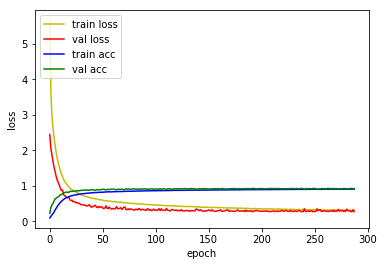

4815/4815 [==============================] - 2s 432us/sample - loss: 0.3087 - acc: 0.9097
Loss: 0.3087116699352443 Accuracy: 0.9096573

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 4.8162 - acc: 0.1184
Epoch 00001: val_loss improved from inf to 2.21194, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_BN_6_conv_checkpoint/001-2.2119.hdf5
36805/36805 [==============================] - 38s 1ms/sample - loss: 4.8161 - acc: 0.1184 - val_loss: 2.2119 - val_acc: 0.2909
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.0597 - acc: 0.2060
Epoch 00002: val_loss improved from 2.21194 to 1.54305, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_BN_6_conv_checkpoint/002-1.5431.hdf5
36805/36805 [==============================] - 30s 824us/sample - loss: 3.0599 - acc: 0.2060 - val_loss: 1.5431 - val_acc: 0.5695
Epoch 3/500
36800/36805 [======================

36800/36805 [============================>.] - ETA: 0s - loss: 0.5139 - acc: 0.8420
Epoch 00022: val_loss improved from 0.29446 to 0.29143, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_BN_6_conv_checkpoint/022-0.2914.hdf5
36805/36805 [==============================] - 30s 828us/sample - loss: 0.5142 - acc: 0.8420 - val_loss: 0.2914 - val_acc: 0.9178
Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4926 - acc: 0.8450
Epoch 00023: val_loss improved from 0.29143 to 0.27247, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_BN_6_conv_checkpoint/023-0.2725.hdf5
36805/36805 [==============================] - 30s 825us/sample - loss: 0.4927 - acc: 0.8450 - val_loss: 0.2725 - val_acc: 0.9238
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4862 - acc: 0.8492
Epoch 00024: val_loss did not improve from 0.27247
36805/36805 [==============================] - 30s 824us/sample - loss: 0.4863 - acc: 0.8

Epoch 47/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3267 - acc: 0.8997
Epoch 00047: val_loss did not improve from 0.20170
36805/36805 [==============================] - 30s 817us/sample - loss: 0.3266 - acc: 0.8997 - val_loss: 0.2827 - val_acc: 0.9185
Epoch 48/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3241 - acc: 0.8998
Epoch 00048: val_loss improved from 0.20170 to 0.20057, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_BN_6_conv_checkpoint/048-0.2006.hdf5
36805/36805 [==============================] - 30s 825us/sample - loss: 0.3241 - acc: 0.8998 - val_loss: 0.2006 - val_acc: 0.9392
Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3173 - acc: 0.9010
Epoch 00049: val_loss did not improve from 0.20057
36805/36805 [==============================] - 30s 820us/sample - loss: 0.3173 - acc: 0.9010 - val_loss: 0.2287 - val_acc: 0.9329
Epoch 50/500
36800/36805 [============================>.

Epoch 73/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2523 - acc: 0.9214
Epoch 00073: val_loss did not improve from 0.16822
36805/36805 [==============================] - 30s 821us/sample - loss: 0.2524 - acc: 0.9214 - val_loss: 0.1743 - val_acc: 0.9481
Epoch 74/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2492 - acc: 0.9229
Epoch 00074: val_loss did not improve from 0.16822
36805/36805 [==============================] - 30s 819us/sample - loss: 0.2492 - acc: 0.9229 - val_loss: 0.1723 - val_acc: 0.9474
Epoch 75/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2532 - acc: 0.9221
Epoch 00075: val_loss did not improve from 0.16822
36805/36805 [==============================] - 30s 819us/sample - loss: 0.2531 - acc: 0.9221 - val_loss: 0.2536 - val_acc: 0.9245
Epoch 76/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2459 - acc: 0.9248
Epoch 00076: val_loss did not improve from 0.16822
36805/36805 [=====

36800/36805 [============================>.] - ETA: 0s - loss: 0.2113 - acc: 0.9336
Epoch 00101: val_loss did not improve from 0.15666
36805/36805 [==============================] - 30s 820us/sample - loss: 0.2113 - acc: 0.9336 - val_loss: 0.1643 - val_acc: 0.9532
Epoch 102/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2071 - acc: 0.9358
Epoch 00102: val_loss did not improve from 0.15666
36805/36805 [==============================] - 30s 822us/sample - loss: 0.2070 - acc: 0.9358 - val_loss: 0.1717 - val_acc: 0.9469
Epoch 103/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2062 - acc: 0.9357
Epoch 00103: val_loss did not improve from 0.15666
36805/36805 [==============================] - 30s 813us/sample - loss: 0.2062 - acc: 0.9357 - val_loss: 0.1683 - val_acc: 0.9495
Epoch 104/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2042 - acc: 0.9368
Epoch 00104: val_loss did not improve from 0.15666
36805/36805 [===============

Epoch 130/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1760 - acc: 0.9440
Epoch 00130: val_loss did not improve from 0.15318
36805/36805 [==============================] - 30s 825us/sample - loss: 0.1760 - acc: 0.9441 - val_loss: 0.1618 - val_acc: 0.9488
Epoch 131/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1766 - acc: 0.9439
Epoch 00131: val_loss did not improve from 0.15318
36805/36805 [==============================] - 30s 827us/sample - loss: 0.1766 - acc: 0.9439 - val_loss: 0.1686 - val_acc: 0.9474
Epoch 132/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1742 - acc: 0.9434
Epoch 00132: val_loss did not improve from 0.15318
36805/36805 [==============================] - 30s 827us/sample - loss: 0.1742 - acc: 0.9434 - val_loss: 0.1762 - val_acc: 0.9469
Epoch 133/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1754 - acc: 0.9432
Epoch 00133: val_loss did not improve from 0.15318
36805/36805 [=

Epoch 160/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1550 - acc: 0.9490
Epoch 00160: val_loss did not improve from 0.15318
36805/36805 [==============================] - 30s 821us/sample - loss: 0.1550 - acc: 0.9490 - val_loss: 0.1750 - val_acc: 0.9464
Epoch 161/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1521 - acc: 0.9508
Epoch 00161: val_loss did not improve from 0.15318
36805/36805 [==============================] - 30s 823us/sample - loss: 0.1520 - acc: 0.9508 - val_loss: 0.1638 - val_acc: 0.9506
Epoch 162/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1488 - acc: 0.9525
Epoch 00162: val_loss did not improve from 0.15318
36805/36805 [==============================] - 30s 823us/sample - loss: 0.1489 - acc: 0.9525 - val_loss: 0.1928 - val_acc: 0.9446
Epoch 163/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1533 - acc: 0.9508
Epoch 00163: val_loss did not improve from 0.15318
36805/36805 [=

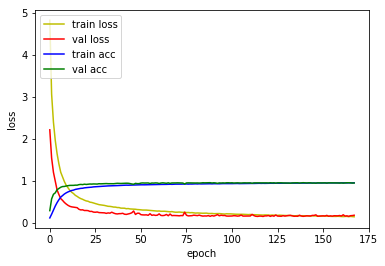

4815/4815 [==============================] - 2s 457us/sample - loss: 0.1886 - acc: 0.9423
Loss: 0.1885629646503294 Accuracy: 0.9422638

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.8668 - acc: 0.1655
Epoch 00001: val_loss improved from inf to 1.85897, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_BN_7_conv_checkpoint/001-1.8590.hdf5
36805/36805 [==============================] - 45s 1ms/sample - loss: 3.8667 - acc: 0.1655 - val_loss: 1.8590 - val_acc: 0.4034
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3257 - acc: 0.3394
Epoch 00002: val_loss improved from 1.85897 to 1.04933, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_BN_7_conv_checkpoint/002-1.0493.hdf5
36805/36805 [==============================] - 32s 871us/sample - loss: 2.3259 - acc: 0.3393 - val_loss: 1.0493 - val_acc: 0.6883
Epoch 3/500
36800/36805 [======================

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3058 - acc: 0.9063
Epoch 00023: val_loss improved from 0.17196 to 0.16852, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_BN_7_conv_checkpoint/023-0.1685.hdf5
36805/36805 [==============================] - 32s 871us/sample - loss: 0.3059 - acc: 0.9063 - val_loss: 0.1685 - val_acc: 0.9525
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2924 - acc: 0.9104
Epoch 00024: val_loss did not improve from 0.16852
36805/36805 [==============================] - 32s 869us/sample - loss: 0.2923 - acc: 0.9104 - val_loss: 0.1719 - val_acc: 0.9497
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2823 - acc: 0.9122
Epoch 00025: val_loss improved from 0.16852 to 0.16243, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_BN_7_conv_checkpoint/025-0.1624.hdf5
36805/36805 [==============================] - 32s 871us/sample - loss: 0.28

36800/36805 [============================>.] - ETA: 0s - loss: 0.1663 - acc: 0.9468
Epoch 00049: val_loss did not improve from 0.13341
36805/36805 [==============================] - 32s 864us/sample - loss: 0.1664 - acc: 0.9468 - val_loss: 0.1408 - val_acc: 0.9562
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1638 - acc: 0.9493
Epoch 00050: val_loss did not improve from 0.13341
36805/36805 [==============================] - 32s 874us/sample - loss: 0.1639 - acc: 0.9492 - val_loss: 0.1392 - val_acc: 0.9592
Epoch 51/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1643 - acc: 0.9485
Epoch 00051: val_loss did not improve from 0.13341
36805/36805 [==============================] - 32s 867us/sample - loss: 0.1642 - acc: 0.9485 - val_loss: 0.1574 - val_acc: 0.9532
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1594 - acc: 0.9501
Epoch 00052: val_loss did not improve from 0.13341
36805/36805 [==================

Epoch 77/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1136 - acc: 0.9643
Epoch 00077: val_loss did not improve from 0.12040
36805/36805 [==============================] - 32s 867us/sample - loss: 0.1136 - acc: 0.9643 - val_loss: 0.1435 - val_acc: 0.9597
Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1126 - acc: 0.9648
Epoch 00078: val_loss did not improve from 0.12040
36805/36805 [==============================] - 32s 873us/sample - loss: 0.1126 - acc: 0.9648 - val_loss: 0.1281 - val_acc: 0.9618
Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1093 - acc: 0.9656
Epoch 00079: val_loss did not improve from 0.12040
36805/36805 [==============================] - 32s 869us/sample - loss: 0.1096 - acc: 0.9655 - val_loss: 0.1329 - val_acc: 0.9609
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1111 - acc: 0.9654
Epoch 00080: val_loss did not improve from 0.12040
36805/36805 [=====

36800/36805 [============================>.] - ETA: 0s - loss: 0.0831 - acc: 0.9731
Epoch 00106: val_loss did not improve from 0.11634
36805/36805 [==============================] - 32s 868us/sample - loss: 0.0832 - acc: 0.9730 - val_loss: 0.1400 - val_acc: 0.9588
Epoch 107/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0883 - acc: 0.9728
Epoch 00107: val_loss did not improve from 0.11634
36805/36805 [==============================] - 32s 867us/sample - loss: 0.0883 - acc: 0.9728 - val_loss: 0.1322 - val_acc: 0.9611
Epoch 108/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0793 - acc: 0.9755
Epoch 00108: val_loss did not improve from 0.11634
36805/36805 [==============================] - 32s 867us/sample - loss: 0.0793 - acc: 0.9755 - val_loss: 0.1282 - val_acc: 0.9646
Epoch 109/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0784 - acc: 0.9752
Epoch 00109: val_loss did not improve from 0.11634
36805/36805 [===============

Epoch 136/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0636 - acc: 0.9799
Epoch 00136: val_loss did not improve from 0.11634
36805/36805 [==============================] - 32s 860us/sample - loss: 0.0636 - acc: 0.9799 - val_loss: 0.1351 - val_acc: 0.9634
Epoch 137/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0634 - acc: 0.9793
Epoch 00137: val_loss did not improve from 0.11634
36805/36805 [==============================] - 32s 863us/sample - loss: 0.0634 - acc: 0.9793 - val_loss: 0.1276 - val_acc: 0.9667
Epoch 138/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0577 - acc: 0.9820
Epoch 00138: val_loss did not improve from 0.11634
36805/36805 [==============================] - 32s 860us/sample - loss: 0.0577 - acc: 0.9820 - val_loss: 0.1433 - val_acc: 0.9613
Epoch 139/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0592 - acc: 0.9814
Epoch 00139: val_loss did not improve from 0.11634
36805/36805 [=

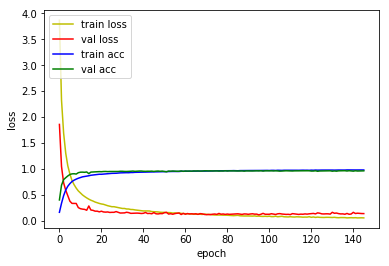

4815/4815 [==============================] - 2s 492us/sample - loss: 0.1573 - acc: 0.9504
Loss: 0.1573159827327555 Accuracy: 0.95036346

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.2943 - acc: 0.2097
Epoch 00001: val_loss improved from inf to 1.67870, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_BN_8_conv_checkpoint/001-1.6787.hdf5
36805/36805 [==============================] - 50s 1ms/sample - loss: 3.2940 - acc: 0.2098 - val_loss: 1.6787 - val_acc: 0.4754
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8379 - acc: 0.4443
Epoch 00002: val_loss improved from 1.67870 to 0.82929, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_BN_8_conv_checkpoint/002-0.8293.hdf5
36805/36805 [==============================] - 33s 899us/sample - loss: 1.8381 - acc: 0.4442 - val_loss: 0.8293 - val_acc: 0.7622
Epoch 3/500
36800/36805 [=====================

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2163 - acc: 0.9345
Epoch 00023: val_loss did not improve from 0.16455
36805/36805 [==============================] - 33s 897us/sample - loss: 0.2163 - acc: 0.9345 - val_loss: 0.1774 - val_acc: 0.9485
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2124 - acc: 0.9347
Epoch 00024: val_loss did not improve from 0.16455
36805/36805 [==============================] - 33s 893us/sample - loss: 0.2126 - acc: 0.9346 - val_loss: 0.1801 - val_acc: 0.9469
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2033 - acc: 0.9378
Epoch 00025: val_loss improved from 0.16455 to 0.16081, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_BN_8_conv_checkpoint/025-0.1608.hdf5
36805/36805 [==============================] - 33s 899us/sample - loss: 0.2033 - acc: 0.9378 - val_loss: 0.1608 - val_acc: 0.9511
Epoch 26/500
36800/36805 [============================>.

Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0983 - acc: 0.9686
Epoch 00051: val_loss did not improve from 0.13553
36805/36805 [==============================] - 33s 896us/sample - loss: 0.0983 - acc: 0.9686 - val_loss: 0.1398 - val_acc: 0.9569
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0948 - acc: 0.9699
Epoch 00052: val_loss did not improve from 0.13553
36805/36805 [==============================] - 33s 892us/sample - loss: 0.0948 - acc: 0.9699 - val_loss: 0.1553 - val_acc: 0.9555
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0912 - acc: 0.9718
Epoch 00053: val_loss did not improve from 0.13553
36805/36805 [==============================] - 33s 895us/sample - loss: 0.0913 - acc: 0.9718 - val_loss: 0.1757 - val_acc: 0.9483
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0948 - acc: 0.9704
Epoch 00054: val_loss did not improve from 0.13553
36805/36805 [=====

36800/36805 [============================>.] - ETA: 0s - loss: 0.0576 - acc: 0.9821
Epoch 00080: val_loss did not improve from 0.13130
36805/36805 [==============================] - 33s 890us/sample - loss: 0.0576 - acc: 0.9821 - val_loss: 0.1421 - val_acc: 0.9623
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0526 - acc: 0.9833
Epoch 00081: val_loss did not improve from 0.13130
36805/36805 [==============================] - 33s 893us/sample - loss: 0.0527 - acc: 0.9833 - val_loss: 0.1521 - val_acc: 0.9597
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0594 - acc: 0.9817
Epoch 00082: val_loss did not improve from 0.13130
36805/36805 [==============================] - 33s 895us/sample - loss: 0.0594 - acc: 0.9817 - val_loss: 0.1657 - val_acc: 0.9578
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0501 - acc: 0.9843
Epoch 00083: val_loss did not improve from 0.13130
36805/36805 [==================


1D_CNN_custom_multi_2_GMP_ch_32_DO_BN_8_conv Model


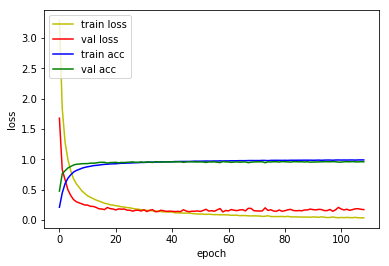

4815/4815 [==============================] - 3s 570us/sample - loss: 0.1795 - acc: 0.9497
Loss: 0.17949633942269028 Accuracy: 0.9497404



In [10]:
base = '1D_CNN_custom_multi_2_GMP_ch_32_DO_BN'

for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    model = build_cnn(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_multi_2_GMP_ch_32_DO_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 9):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_multi_2_GMP_ch_32_DO_BN_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 32)    192         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_33 (Batc (None, 16000, 32)    128         conv1d_33[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 32)    0           batch_normalization_v1_33[0][0]  
_________________________________________________________

4815/4815 [==============================] - 3s 554us/sample - loss: 0.5789 - acc: 0.8243
Loss: 0.5789255082421585 Accuracy: 0.82429904

1D_CNN_custom_multi_2_GMP_ch_32_DO_BN_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 16000, 32)    192         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_40 (Batc (None, 16000, 32)    128         conv1d_40[0][0]                  
__________________________________________________________________________________________________
activation_40 (Activ

4815/4815 [==============================] - 3s 574us/sample - loss: 0.1886 - acc: 0.9423
Loss: 0.1885629646503294 Accuracy: 0.9422638

1D_CNN_custom_multi_2_GMP_ch_32_DO_BN_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 16000, 32)    192         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_v1_51 (Batc (None, 16000, 32)    128         conv1d_51[0][0]                  
__________________________________________________________________________________________________
activation_51 (Activa

4815/4815 [==============================] - 3s 638us/sample - loss: 0.1795 - acc: 0.9497
Loss: 0.17949633942269028 Accuracy: 0.9497404


In [12]:
for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_custom_multi_2_GMP_ch_32_DO_BN_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 32)    192         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_33 (Batc (None, 16000, 32)    128         conv1d_33[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 32)    0           batch_normalization_v1_33[0][0]  
_________________________________________________________

4815/4815 [==============================] - 3s 628us/sample - loss: 0.6082 - acc: 0.8160
Loss: 0.6082297337265649 Accuracy: 0.8159917

1D_CNN_custom_multi_2_GMP_ch_32_DO_BN_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 16000, 32)    192         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_40 (Batc (None, 16000, 32)    128         conv1d_40[0][0]                  
__________________________________________________________________________________________________
activation_40 (Activa

4815/4815 [==============================] - 3s 694us/sample - loss: 0.2124 - acc: 0.9387
Loss: 0.2124126176627378 Accuracy: 0.9387331

1D_CNN_custom_multi_2_GMP_ch_32_DO_BN_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 16000, 32)    192         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_v1_51 (Batc (None, 16000, 32)    128         conv1d_51[0][0]                  
__________________________________________________________________________________________________
activation_51 (Activa

4815/4815 [==============================] - 3s 707us/sample - loss: 0.2183 - acc: 0.9493
Loss: 0.21832625797987448 Accuracy: 0.949325
